In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

In [0]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

db = load_iris()

Text(0, 0.5, 'petal width (cm)')

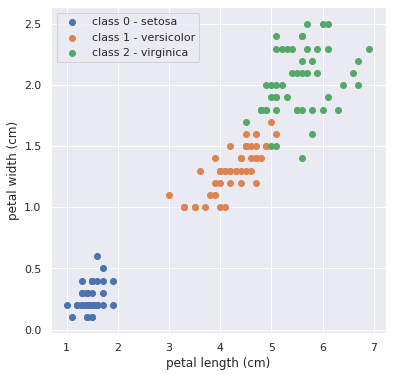

In [36]:
X = db.data[:, 2:]
y = db.target
targets = db.target_names
feat_names = db.feature_names[2:]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for idx, target in enumerate(targets):
    ax.scatter(X[np.where(y==idx), 0], X[np.where(y==idx), 1], label=f'class {idx} - {target}')
ax.legend()
ax.set_xlabel(feat_names[0])
ax.set_ylabel(feat_names[1])

In [11]:
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

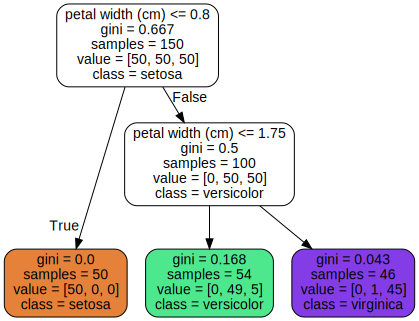

In [35]:
from sklearn.tree import export_graphviz
from graphviz import Source

graph = export_graphviz(tree_clf, feature_names=feat_names, class_names=targets, 
                        leaves_parallel=True, rounded=True, filled=True)
graph_source = Source(graph)
graph_source

Text(0, 0.5, 'petal width (cm)')

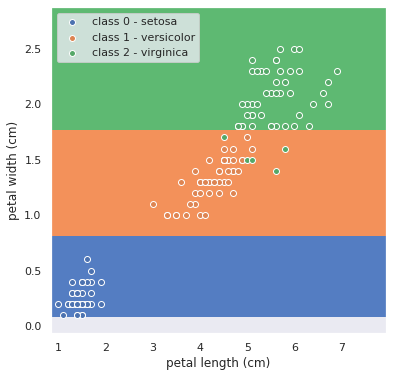

In [95]:
from matplotlib.colors import ListedColormap

steps = 100
percent = 0.15
# TODO: repair min, max value according to all range
x0_min, x0_max = np.min(X[:, 0]) * (1-percent), np.max(X[:, 0]) * (1 + percent)
x1_min, x1_max = np.min(X[:, 1]) * (1-percent), np.max(X[:, 1]) * (1 + percent)

x0_values = np.linspace(x0_min, x0_max, steps);
x1_values = np.linspace(x1_min, x1_max, steps);

xx0, xx1 = np.meshgrid(x0_values, x1_values)
z = tree_clf.predict(np.c_[xx0.ravel(), xx1.ravel()])
z = z.reshape(xx0.shape)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

current_palette = sns.color_palette()
# TODO: repair color palete - maybe add some shading?
ax.pcolormesh(xx0, xx1, z, cmap=ListedColormap(np.array(current_palette)[:len(targets)] * 1.1))
for idx, target in enumerate(targets):
    ax.scatter(X[np.where(y==idx), 0], X[np.where(y==idx), 1], label=f'class {idx} - {target}', ec='w')
    ax.legend()
ax.set_xlabel(feat_names[0])
ax.set_ylabel(feat_names[1])

In [90]:
x1_min

0.085

([(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
  (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
  (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
  (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
  (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
  (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
  (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
  (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
  (0.8, 0.7254901960784313, 0.4549019607843137),
  (0.39215686274509803, 0.7098039215686275, 0.803921568627451)],
 array([[0.20862745, 0.31294118, 0.48313725],
        [0.60666667, 0.36235294, 0.22509804],
        [0.23333333, 0.46117647, 0.2854902 ],
        [0.53803922, 0.21411765, 0.22509804],
        [0.35411765, 0.31294118, 0.49137255],
        [0.40352941, 0.32941176, 0.26352941],
        [0.59843137, 0.38156863, 0.53529412],
        [0.38431373, 0.38431373, 0.38431373],
    